# Previsão de renda

### 4 elementos importantes
- Esse notebook
- Streamlit com as análises
- Seu Github com o projeto
- Vídeo no readme do github mostrando o streamlit

## Etapa 1 CRISP - DM: Entendimento do negócio 

&nbsp;

<span style="color:red"> 
    
A instituição financeira XY deseja uma análise profunda do perfil dos seus clientes atuais e um bom modelo de previsão de renda para novos clientes que ingressarem na instituição.
   
Para termos esses resultados, primeiro vamos fazer análises dos dados que temos disponíveis no banco de dados (que serão analisados detalhadamente na próxima etapa) e depois iremos criar o sistema de modelagem.
    
Nosso objetivo principal nesse projeto será entender melhor quem é o consumidor final da instituição financeira e, por consequência, atender melhor os clientes baseado em seu perfil e renda.
    
Aqui no Notebook, vamos focar em fazer a modelagem do sistema para previsão de renda e na página web do Streamlit, vamos identificar o perfil dos clientes.
    
</span>


## Etapa 2 Crisp-DM: Entendimento dos dados

&nbsp;

<span style="color:red">

Para começar o projeto, vamos importar os pacotes e o arquivo do banco de dados.
    
</span>

In [17]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import statsmodels.api as sm
import patsy

from sklearn.model_selection import train_test_split
from ydata_profiling import ProfileReport

%matplotlib inline

In [18]:
renda = pd.read_csv('./input/previsao_de_renda.csv')

### Dicionário de dados

&nbsp;

<span style="color:red"> 

Agora vamos ver as informações que temos e seu tipo.
    
<span/>
    
&nbsp;

| Variável                | Descrição                                           | Tipo         |
| ----------------------- |:---------------------------------------------------:| ------------:|
| data_ref                |  Data em que a informação foi adicionada no banco de dados    | object       |
| id_cliente              |  ID único de cada cliente que o banco atribuiu a ele    | int64        |
| sexo                    |  Gênero do cliente    | object       |
| posse_de_veiculo        |  Se possui ou não veículo    | bool         |
| posse_de_imovel         |  Se possui ou não imóvel    | bool         |
| qtd_filhos              |  Quantidade de filhos    | int64        |
| tipo_renda              |  Qual a fonte da sua renda    | object       |
| educacao                |  Nível de escolaridade    | object       |
| estado_civil            |  Estado civil do cliente    | object       |
| tipo_residencia         |  Qual o tipo de residência    | object       |
| idade                   |  Idade do cliente    | int64        |
| tempo_emprego           |  Tempo no emprego atual    | float64      |
| qt_pessoas_residencia   |  Quantas pessoas moram com o cliente    | float64      |
| renda                   |  Sua renda    | float64      |

In [19]:
renda.sample(1)

Unnamed: 0    data_ref  id_cliente sexo  posse_de_veiculo  \
11851       11851  2015-12-01       10353    M              True   

       posse_de_imovel  qtd_filhos        tipo_renda    educacao estado_civil  \
11851            False           1  Servidor público  Secundário       Casado   

      tipo_residencia  idade  tempo_emprego  qt_pessoas_residencia    renda  
11851     Com os pais     41       3.383562                    3.0  8186.44

#### Entendimento dos dados - Univariada e Bivariada

<span style="color:red">

Vamos fazer agora uma análise mais detalhada dos dados usando o Profile Report.

</span>



In [20]:
prof = ProfileReport(renda)
prof

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [21]:
prof.to_file('./output/renda_analisys.html')

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

<span style="color:red">

Com essa análise, percebemos que o nosso banco de dados está bem robusto. Os missings estão concentrados na variável 'tempo_emprego', o que significa que o cliente não está empregado ou tem outra fonte de renda. E um alto número de zeros pode ser encontrado em 'qtd_filhos' que simplesmente quer dizer que o cliente não tem filhos.
    
Alguns problemas encontrados que vamos resolver banco de dados são:
 - Excluir linhas duplicadas (se houver);
 - Excluir as variáveis 'Unnamed: 0', 'data_ref' e 'id_cliente' que não interferem na análise;
 - Podemos notar que a variável 'tipo_residencia' está com 90% dos valores 'Casa', então vamos excluir também da análise;
 - As variáveis 'qtd_filhos' e 'qt_pessoas_residencia' são altamente relacionadas, e por isso, vamos manter apenas 'qt_pessoas_residencia';
 - Transformar a variável 'sexo' em bool, sendo M equivalente a 1 e F a 0;
 - Transformar 'qt_pessoas_residencia' em int;	
 - Transformar os NaN values de 'tempo_emprego' em 0.

</span>

## Etapa 3 Crisp-DM: Preparação dos dados
Nessa etapa realizamos tipicamente as seguintes operações com os dados:

 - **seleção**: Já temos os dados selecionados adequadamente?
 - **limpeza**: Precisaremos identificar e tratar dados faltantes
 - **construção**: construção de novas variáveis
 - **integração**: Temos apenas uma fonte de dados, não é necessário integração
 - **formatação**: Os dados já se encontram em formatos úteis?

<span style="color:red">

Seguindo as observações do passo anterior, vamos preparar os dados para deixar o DataFrame o mais robusto e funcional possível.
    
</span>

In [22]:
# Exluindo linhas duplicadas

renda.drop_duplicates(inplace = True)

# Excluindo colunas

renda.drop(columns = ['Unnamed: 0', 'data_ref', 'id_cliente', 'tipo_residencia', 'qtd_filhos'], inplace = True) 

# Convertendo 'sexo' em bool

sexo = {'M' : 1, 'F' : 0}

renda['sexo'] = renda['sexo'].map(sexo).astype(bool)

# Transformando 'qt_pessoas_residencia' em int

renda['qt_pessoas_residencia'] = renda['qt_pessoas_residencia'].astype(int)

# Transformando NaN values em 0

renda.fillna(0, inplace = True)

In [23]:
# Checando o DataFrame com alterações

renda.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   sexo                   15000 non-null  bool   
 1   posse_de_veiculo       15000 non-null  bool   
 2   posse_de_imovel        15000 non-null  bool   
 3   tipo_renda             15000 non-null  object 
 4   educacao               15000 non-null  object 
 5   estado_civil           15000 non-null  object 
 6   idade                  15000 non-null  int64  
 7   tempo_emprego          15000 non-null  float64
 8   qt_pessoas_residencia  15000 non-null  int32  
 9   renda                  15000 non-null  float64
dtypes: bool(3), float64(2), int32(1), int64(1), object(3)
memory usage: 805.8+ KB


<span style="color:red">

Podemos perceber que agora só temos as variáveis necessárias para a análise e não temos nenhum dado faltante. Além disso, todas as variáveis estão no tipo correto para a análise.
    
Agora vamos analisar se existem outliers na variável resposta 'renda'.
    
</span>

In [24]:
renda['renda'].describe()

count     15000.000000
mean       5697.287057
std        8266.816289
min         118.710000
25%        2026.110000
50%        3499.720000
75%        6392.167500
max      245141.670000
Name: renda, dtype: float64

<span style="color:red">

É notável que a variável renda tem muitos outliers já que até o terceiro quartil, temos 6.300 de renda e o valor máximo é de 245.000. Por isso, vamos eliminar 6% dos valores mais altos.
    
</span>

In [25]:
renda['renda'].quantile(0.94)

15432.500999999997

In [26]:
renda = renda[(renda['renda'] < 15000)]
renda.shape

(14046, 10)

In [27]:
# Dividindo o DF em treino e teste para a etapa de criação do modelo

train, test = train_test_split (renda, train_size = 0.75)

## Etapa 4 Crisp-DM: Modelagem
Nessa etapa que realizaremos a construção do modelo. Os passos típicos são:
- Selecionar a técnica de modelagem
- Desenho do teste
- Avaliação do modelo


<span style="color:red">

Vamos desenvolver um modelo de regressão para prever a renda no nosso DF já dividido em treino e teste e depois criaremos o modelo.
    
</span>

### Rodando o modelo


In [28]:
# Criando o modelo de regressão

reg_renda = smf.ols('renda ~ sexo + posse_de_veiculo + posse_de_imovel + tipo_renda + educacao + estado_civil + idade + tempo_emprego + qt_pessoas_residencia', data = train).fit()
reg_renda.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  renda   R-squared:                       0.243
Model:                            OLS   Adj. R-squared:                  0.242
Method:                 Least Squares   F-statistic:                     187.7
Date:                Wed, 10 Apr 2024   Prob (F-statistic):               0.00
Time:                        18:56:22   Log-Likelihood:                -97981.
No. Observations:               10534   AIC:                         1.960e+05
Df Residuals:                   10515   BIC:                         1.961e+05
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                         983.1617    316.630      3.105      0.002     362.506    1603.817
sexo[T.True]                     2576.1234     62.724     41.071      0.000    2453.172    2699.074
posse_de_veiculo[T.True]           57.2270     57.973      0.987      0.324     -56.411     170.865
posse_de_imovel[T.True]           326.2832     56.128      5.813      0.000     216.262     436.304
tipo_renda[T.Bolsista]            430.3891    940.712      0.458      0.647   -1413.585    2274.363
tipo_renda[T.Empresário]          541.2684     65.443      8.271      0.000     412.988     669.548
tipo_renda[T.Pensionista]         893.0651    104.439      8.551      0.000     688.344    1097.786
tipo_renda[T.Servidor público]    281.6906     99.020      2.845      0.004      87.592     475.789
educacao[T.Pós graduação]         -45.4000    610.732     -0.074      0.941   -1242.551    1151.751
educacao[T.Secundário]           -249.8940    256.847     -0.973      0.331    -753.362     253.574
educacao[T.Superior completo]     111.3207    259.053      0.430      0.667    -396.472     619.113
educacao[T.Superior incompleto]  -405.2866    288.112     -1.407      0.160    -970.040     159.467
estado_civil[T.Separado]          -56.2424    121.540     -0.463      0.644    -294.483     181.998
estado_civil[T.Solteiro]          -69.2650     96.335     -0.719      0.472    -258.100     119.570
estado_civil[T.União]             -39.8902     99.973     -0.399      0.690    -235.856     156.075
estado_civil[T.Viúvo]             183.8605    128.198      1.434      0.152     -67.432     435.152
idade                              14.7854      3.347      4.417      0.000       8.224      21.347
tempo_emprego                     195.1555      4.976     39.217      0.000     185.401     204.910
qt_pessoas_residencia             101.1753     37.382      2.707      0.007      27.900     174.451
==============================================================================
Omnibus:                     1674.840   Durbin-Watson:                   1.969
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2773.582
Skew:                           1.068   Prob(JB):                         0.00
Kurtosis:                       4.327   Cond. No.                     1.66e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.66e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [29]:
# Vamos retirando do modelo as variáveis que não interferem no objetivo

modelo_filtrado = 'renda ~ sexo + posse_de_imovel + idade + tempo_emprego + qt_pessoas_residencia'

reg = smf.ols(modelo_filtrado, data = train).fit()
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  renda   R-squared:                       0.230
Model:                            OLS   Adj. R-squared:                  0.230
Method:                 Least Squares   F-statistic:                     630.2
Date:                Wed, 10 Apr 2024   Prob (F-statistic):               0.00
Time:                        18:56:22   Log-Likelihood:                -98069.
No. Observations:               10534   AIC:                         1.962e+05
Df Residuals:                   10528   BIC:                         1.962e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 807.7219    157.138      5.140      0.000     499.701    1115.743
sexo[T.True]             2507.3630     59.376     42.229      0.000    2390.975    2623.751
posse_de_imovel[T.True]   347.9016     56.370      6.172      0.000     237.406     458.397
idade                      26.6603      2.531     10.534      0.000      21.699      31.621
tempo_emprego             175.2735      4.283     40.919      0.000     166.877     183.670
qt_pessoas_residencia      91.4319     30.399      3.008      0.003      31.843     151.020
==============================================================================
Omnibus:                     1676.733   Durbin-Watson:                   1.970
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2752.240
Skew:                           1.075   Prob(JB):                         0.00
Kurtosis:                       4.283   Cond. No.                         280.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

O R² do modelo é 23.03%.
O MSE do modelo é 4504173022.


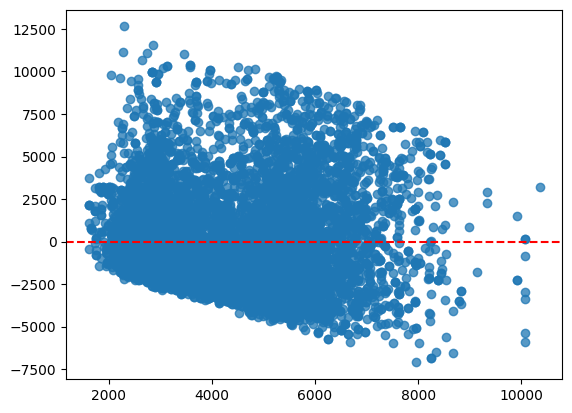

In [30]:
# Estudando o resíduo no df de treino

print(f'O R² do modelo é {reg.rsquared*100:.2f}%.')
print(f'O MSE do modelo é {reg.mse_model:.0f}.')

y_pred = reg.predict(train)

residuos = reg.resid

plt.scatter(y_pred, residuos,  alpha = .75)
plt.axhline(y = 0, color = 'r', linestyle = '--')

## Etapa 5 Crisp-DM: Avaliação dos resultados


<span style="color:red">
    
Agora vamos usar a modelagem na base de testes. 
   
</span>

In [31]:
# Comparando resultados no df de test

reg = smf.ols(modelo_filtrado, data = test).fit()
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  renda   R-squared:                       0.239
Model:                            OLS   Adj. R-squared:                  0.238
Method:                 Least Squares   F-statistic:                     219.9
Date:                Wed, 10 Apr 2024   Prob (F-statistic):          1.36e-204
Time:                        18:56:23   Log-Likelihood:                -32721.
No. Observations:                3512   AIC:                         6.545e+04
Df Residuals:                    3506   BIC:                         6.549e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                1264.0888    272.375      4.641      0.000     730.060    1798.118
sexo[T.True]             2552.3750    102.854     24.815      0.000    2350.715    2754.035
posse_de_imovel[T.True]   257.0881     98.242      2.617      0.009      64.472     449.704
idade                      20.0748      4.389      4.574      0.000      11.469      28.681
tempo_emprego             175.9424      7.409     23.748      0.000     161.417     190.468
qt_pessoas_residencia      48.6672     55.173      0.882      0.378     -59.507     156.841
==============================================================================
Omnibus:                      568.785   Durbin-Watson:                   2.035
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              931.433
Skew:                           1.085   Prob(JB):                    5.52e-203
Kurtosis:                       4.289   Cond. No.                         276.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

O R² do modelo é 23.87%.
O MSE do modelo é 1595779685.


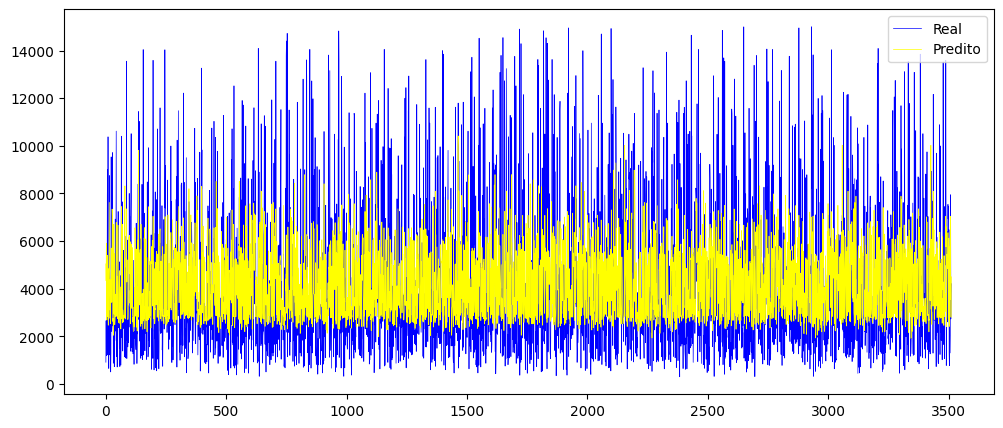

In [32]:
print(f'O R² do modelo é {reg.rsquared*100:.2f}%.')
print(f'O MSE do modelo é {reg.mse_model:.0f}.')

y_pred = reg.predict(test)

y_true = test['renda']

indices = range(len(y_true))

plt.figure(figsize = (12,5))
plt.plot(indices, y_true, linewidth = .5, color = 'blue')
plt.plot(indices, y_pred, linewidth = .5, color = 'yellow')
plt.legend(['Real', 'Predito'])

<span style="color:red">

Vemos uma melhora no R² e no MSE da base de testes. Isso nos mostra que a regressão foi bem sucedida e não está com overfitting.
    
</span>

## Etapa 6 Crisp-DM: Implantação

<span style="color:red">

Agora com todas as tomadas de decisão bem definidas, qualquer nova entrada no dataframe vai sofrer as mesmas modificações feitas na etapa 3 e usar o modelo definido na etapa 4. 
    
Também pode ser desenvolvido um script com todas essas informações e que, ao receber um novo DataFrame com dados de novos clientes, poderá automaticamente realizar todos esses passos e trazer a análise pronta.
    
Dessa forma, a instituição terá maior poder de tomada de decisão no que se refere a concessão de crédito e serviços mais apropriados ao perfil do cliente.

</span>